In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import importlib
import numpy as np
import os, sys
import json
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../utils/'))

# local modules
import get_oms_data
# importlib.reload(get_oms_data)  # not needed unless making live changes to the modules
from get_oms_data import get_oms_api, get_oms_data, get_oms_response_attribute

import json_utils as jsonu
import plot_utils as pu

import mplhep as hep
hep.style.use("CMS")

import OMS_RR_utils
# importlib.reload(OMS_RR_utils) 
import json_utils
import OMS_RR_utils as omsu
from refruns_utils import get_reference_run as RRfetch
import refrank_utils as rrr
# importlib.reload(rrr)

# Getting the Data

We start by instantiating the OMS API. The OMS API will be used to get Run and LS level data and will be the main source of information for the reference run ranking (RRR) system.

In [24]:
omsapi = get_oms_api()

<h2>Data selection</h2>

We select the range of runs and define the list which we will pass to the OMS API which will tell it what attributes we wish to obtain for each run/LS.

In [2]:
# Run we wish to certify and for which we will find a correspond reference run
target = 316201
oldest_run = target - 1011

# Range of runs of interest
run_range = (oldest_run, target)
print(run_range)

(315190, 316201)


In [3]:
# Run level attributes
run_attribs = [
    'components', 
    'init_lumi',
    'recorded_lumi', 
    'delivered_lumi',
    'start_time',
    'end_time',
    'energy', 
    'end_lumi', 
    'hlt_physics_rate',
    'fill_number', 
    'l1_hlt_mode', 
    'trigger_mode',
    'l1_key_stripped', 
    'fill_type_party2',
    'fill_type_party1', 
    'initial_prescale_index',
    'sequence', 
    'hlt_physics_size', 
    'fill_type_runtime',
    'last_lumisection_number', # refers to the last LSs where cms_active is True
    'l1_rate',
    'l1_menu', 
    'run_number',
    'stable_beam',
    'hlt_physics_counter',
#     'peak_pileup' <-- Find actual name
]

In [4]:
# Lumisecion (LS) level attributes
ls_attribs = [
    'fill_number',
    "run_number",
    'lumisection_number',
    "physics_flag",
    "cms_active",
    'bpix_ready',
    'fpix_ready',
    'tecm_ready',
    'tecp_ready',
    'tibtid_ready',
    'tob_ready',
    'pileup',
    'delivered_lumi',
    'recorded_lumi',
    "init_lumi",
    'end_lumi',
    'beam1_stable',
    'beam2_stable',
    'beam2_present',
    'beam1_present'
]

<h1><font color='blue'> Loading and Basic Filtering of Data</font></h1>
<h2> Run Level Data </h2>

Loading in the data using `get_oms_data`. Note that this will give us a JSON, so we will go on to put the data into a dataframe.

In [34]:
# Load data into JSON
run_json = get_oms_data(
    omsapi, 
    'runs', 
    run_range, 
#     limit_entries = 100000,
    limit_entries = 5_000,
    attributes = run_attribs
)

https://vocms0185.cern.ch/agg/api/v1/runs/?fields=l1_rate,stable_beam,energy,start_time,end_lumi,hlt_physics_counter,last_lumisection_number,fill_type_party1,components,run_number,hlt_physics_rate,trigger_mode,hlt_physics_size,delivered_lumi,l1_key_stripped,initial_prescale_index,init_lumi,recorded_lumi,sequence,l1_hlt_mode,end_time,fill_type_runtime,fill_type_party2,l1_menu,fill_number&filter[run_number][GE]=315190&filter[run_number][LE]=316201&page[offset]=0&page[limit]=5000
https://vocms0185.cern.ch/agg/api/v1/runs/?fields=l1_rate,stable_beam,energy,start_time,end_lumi,hlt_physics_counter,last_lumisection_number,fill_type_party1,components,run_number,hlt_physics_rate,trigger_mode,hlt_physics_size,delivered_lumi,l1_key_stripped,initial_prescale_index,init_lumi,recorded_lumi,sequence,l1_hlt_mode,end_time,fill_type_runtime,fill_type_party2,l1_menu,fill_number&filter[run_number][GE]=315190&filter[run_number][LE]=316201&page[offset]=0&page[limit]=5000


In [36]:
run_json['data'][0]

{'id': '315190',
 'type': 'runs',
 'attributes': {'components': ['CSC',
   'CTPPS',
   'CTPPS_TOT',
   'DAQ',
   'DCS',
   'DQM',
   'DT',
   'ECAL',
   'ES',
   'HCAL',
   'PIXEL',
   'RPC',
   'SCAL',
   'TCDS',
   'TRACKER',
   'TRG'],
  'init_lumi': 0.363443823242,
  'recorded_lumi': 7.5812421875,
  'delivered_lumi': 7.945421875,
  'energy': 6499.0,
  'end_lumi': 1.6508e-08,
  'hlt_physics_rate': 1394.998,
  'fill_number': 6614,
  'l1_hlt_mode': 'collisions2018',
  'end_time': '2018-04-26T07:13:45Z',
  'trigger_mode': 'l1_hlt_collisions2018/v66',
  'l1_key_stripped': 'collisions2018/v9',
  'fill_type_party2': 'PROTON',
  'fill_type_party1': 'PROTON',
  'initial_prescale_index': 1,
  'sequence': 'GLOBAL-RUN',
  'start_time': '2018-04-26T06:28:12Z',
  'hlt_physics_size': 3013.917,
  'fill_type_runtime': 'PROTONS',
  'last_lumisection_number': 115,
  'l1_rate': 51943.05,
  'l1_menu': 'L1Menu_Collisions2018_0_0_1',
  'run_number': 315190,
  'stable_beam': True,
  'hlt_physics_counter':

<br>
We proceed to convert it into a Pandas Dataframe for ease of use and to use all the tools Pandas has to offer.
<br><br>

In [37]:
# Convert JSON into DF
run_df = omsu.makeDF(run_json).convert_dtypes()

In [38]:
# Optional: Save to csv
run_df.to_csv('/eos/user/r/rcruzcan/SWAN_projects/RefRunRank/data/run_df.csv')

In [32]:
# Optional: Load from csv
run_df = pd.read_csv('/eos/user/r/rcruzcan/SWAN_projects/RefRunRank/data/run_df.csv')

In [39]:
len(run_df)

653

<br>

There is a problem with the data: some of the rows has `fill_number = NaN`. This is problematic, so we will segment the rows into those that have this problem (`run_df_NaN`), and the rest (`run_df`). We also add `Fill Location` column and make the `run_number` column into an index column.

<font color='red'> INVESTIGATE WHY THESE RUNS/LSs HAVE NaN VALUES. FIGURE WHERE THESE LSs TEND TO HAPPEN (START OR END OF THE RUN). </font>

In [40]:
# Filter out runs that have NaN in fill number
run_df, run_df_NaN = omsu.has_fill(run_df)
print(
    '''
    Runs kept in run dataframe: {}
    Runs filtered out: {}
    Lowest run # kept: {}
    Highest run # kept: {}
    '''.format(
        len(run_df['run_number'].unique()), 
        len(run_df_NaN['run_number'].unique()),
        run_df['run_number'].min(),
        run_df['run_number'].max())
)

run_df = omsu.add_loc_wrt_fill(run_df)

run_df.set_index(['run_number'], inplace=True)
run_df.sort_index(level=['run_number'], inplace=True)


    Runs kept in run dataframe: 416
    Runs filtered out: 237
    Lowest run # kept: 315190
    Highest run # kept: 316201
    


/eos/home-i02/r/rcruzcan/SWAN_projects/RefRunRank/notebooks/OMS_RR_utils.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfcopy['Fill location'].iloc[count]="({}/{})".format(x,i)


We can now take a look at the data that was filtered out and the run data that is left

In [41]:
run_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 416 entries, 315190 to 316201
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   components               416 non-null    object 
 1   init_lumi                416 non-null    Float64
 2   recorded_lumi            416 non-null    Float64
 3   delivered_lumi           416 non-null    Float64
 4   energy                   416 non-null    Int64  
 5   end_lumi                 416 non-null    Float64
 6   hlt_physics_rate         374 non-null    Float64
 7   fill_number              416 non-null    Int64  
 8   l1_hlt_mode              416 non-null    string 
 9   end_time                 416 non-null    string 
 10  trigger_mode             416 non-null    string 
 11  l1_key_stripped          416 non-null    string 
 12  fill_type_party2         416 non-null    string 
 13  fill_type_party1         416 non-null    string 
 14  initial_prescale_index 

<h2>LS Level Data</h2>

We use the OMS API to get LS level data on the same runs that were obtained above.

In [42]:
ls_json = get_oms_data(
    omsapi, 
    'lumisections', 
    run_range, 
    limit_entries=100_000,
    attributes=ls_attribs
)

https://vocms0185.cern.ch/agg/api/v1/lumisections/?fields=cms_active,tob_ready,end_lumi,beam2_present,pileup,lumisection_number,run_number,beam1_stable,physics_flag,delivered_lumi,beam2_stable,init_lumi,beam1_present,recorded_lumi,tibtid_ready,fpix_ready,tecm_ready,fill_number,bpix_ready,tecp_ready&filter[run_number][GE]=315190&filter[run_number][LE]=316201&page[offset]=0&page[limit]=100000
https://vocms0185.cern.ch/agg/api/v1/lumisections/?fields=cms_active,tob_ready,end_lumi,beam2_present,pileup,lumisection_number,run_number,beam1_stable,physics_flag,delivered_lumi,beam2_stable,init_lumi,beam1_present,recorded_lumi,tibtid_ready,fpix_ready,tecm_ready,fill_number,bpix_ready,tecp_ready&filter[run_number][GE]=315190&filter[run_number][LE]=316201&page[offset]=0&page[limit]=100000


In [92]:
ls_json['data'][0]

{'id': '314206_1',
 'type': 'lumisections',
 'attributes': {'fill_number': 6554,
  'beam1_present': True,
  'physics_flag': False,
  'tecp_ready': False,
  'bpix_ready': False,
  'tecm_ready': False,
  'lumisection_number': 1,
  'cms_active': True,
  'tibtid_ready': False,
  'fpix_ready': False,
  'beam1_stable': False,
  'tob_ready': False,
  'init_lumi': 0.000925551224,
  'pileup': 0.0,
  'run_number': 314206,
  'recorded_lumi': 0.0,
  'delivered_lumi': 0.0,
  'beam2_stable': False,
  'end_lumi': 0.000923896503,
  'beam2_present': True},
 'links': {'self': 'https://https://vocms0185.cern.ch/agg/api/v1/lumisections/314206_1'},
 'meta': {'row': {'init_lumi': {'units': '10^{34}cm^{-2}s^{-1}'},
   'recorded_lumi': {'units': 'pb^{-1}'},
   'delivered_lumi': {'units': 'pb^{-1}'},
   'end_lumi': {'units': '10^{34}cm^{-2}s^{-1}'}}}}

We proceed to put the data into a Pandas Dataframe, put aside rows that have `fill_number = NaN`, add a fill location row and turn the `run_number` and `lumisection_number` columns into index columns.

In [43]:
ls_df = omsu.makeDF(ls_json)

In [ ]:
# Optional: Save to csv
ls_df.to_csv('/eos/user/r/rcruzcan/SWAN_projects/RefRunRank/data/ls_df.csv')

In [9]:
# Optional: Load from csv
ls_df = pd.read_csv('/eos/user/r/rcruzcan/SWAN_projects/RefRunRank/data/ls_df.csv')

In [44]:
ls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63020 entries, 0 to 63019
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   fill_number         62469 non-null  float64
 1   beam1_present       63020 non-null  bool   
 2   physics_flag        63020 non-null  bool   
 3   tecp_ready          63020 non-null  bool   
 4   bpix_ready          63020 non-null  bool   
 5   tecm_ready          63020 non-null  bool   
 6   lumisection_number  63020 non-null  int64  
 7   cms_active          63020 non-null  bool   
 8   tibtid_ready        63020 non-null  bool   
 9   fpix_ready          63020 non-null  bool   
 10  beam1_stable        63020 non-null  bool   
 11  tob_ready           63020 non-null  bool   
 12  init_lumi           62464 non-null  float64
 13  pileup              63015 non-null  float64
 14  run_number          63020 non-null  int64  
 15  recorded_lumi       62464 non-null  float64
 16  deli

In [45]:
ls_df, ls_df_NaN = omsu.has_fill(ls_df)
print(
    '''
    Runs kept in lumisection dataframe: {}
    Runs filtered out: {}
    Lowest run # kept: {}
    Highest run # kept: {}
    '''.format(
        len(ls_df['run_number'].unique()),   
        len(ls_df_NaN['run_number'].unique()),
        ls_df['run_number'].min(),
        ls_df['run_number'].max()
    )
)

ls_df = omsu.add_loc_wrt_fill(ls_df)
ls_df = ls_df.convert_dtypes()

ls_df.set_index(['run_number', 'lumisection_number'], inplace=True)
ls_df.sort_index(level=['run_number', 'lumisection_number'], inplace=True)


    Runs kept in lumisection dataframe: 412
    Runs filtered out: 13
    Lowest run # kept: 315190
    Highest run # kept: 316201
    


/eos/home-i02/r/rcruzcan/SWAN_projects/RefRunRank/notebooks/OMS_RR_utils.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfcopy['Fill location'].iloc[count]="({}/{})".format(x,i)


<h2> Data checks </h2>

There might be runs which appear in one of the dataframes, but not the other. We check which runs are these and exclude them so that both dataframes have the same runs.

<font color='red'>

In [46]:
rundf_runs = run_df.index.to_list()
lsdf_runs = ls_df.index.get_level_values(0)

# Finding symmetric different
missing_runs = list(set(rundf_runs) ^ set(lsdf_runs))
print(
    '''
    List of runs which are in one of the dataframes, but not the other (and viceversa): \n    {}
    '''.format(missing_runs)
)

# Going through each dataframe and deleting these runs
for run in missing_runs:
    if run in rundf_runs:
        run_df.drop(run, inplace=True)
    else:
        ls_df.drop(run, inplace=True)


    List of runs which are in one of the dataframes, but not the other (and viceversa): 
    [316100, 315230, 315233, 315241]
    


In [47]:
rundf_runs = run_df.index.to_list()
lsdf_runs = ls_df.index.get_level_values(0)

# Finding symmetric different
missing_runs = list(set(rundf_runs) ^ set(lsdf_runs))
print(
    '''
    List of runs which are in one of the dataframes, but not the other (and viceversa): \n    {}
    '''.format(missing_runs)
)


    List of runs which are in one of the dataframes, but not the other (and viceversa): 
    []
    


In [48]:
print(
    '''
    Number of runs in the run dataframe: {}
    Number of runs in the lumisection dataframe: {}
    Are the runs contained in these dataframes exactly the same?: {}
    '''.format(
        len(run_df.index.unique()),
        len(ls_df.index.get_level_values(0).unique()),
        run_df.index.unique().tolist() == ls_df.index.get_level_values(0).unique().tolist()
    )
)


    Number of runs in the run dataframe: 412
    Number of runs in the lumisection dataframe: 412
    Are the runs contained in these dataframes exactly the same?: True
    


<h1><font color='blue'>Segmenting Data To Use in RRR Testing</font></h1>

Golden Jsons to be used
<!-- <font color='red'>THESE GOLDEN JSONS ARE TOO OLD, AND THEY ARE GLOBAL. SHOULD FOCUS ON TRK SO FILTERING IS NOT SO AGGRESIVE.</font> -->
<font color='red'>MAKE NEW GOLDEN JSON FOR NEW RANGE OF RUNS</font>

In [49]:
golden_files = [
    'json_GOLDEN_2017.json', 
    'json_GOLDEN_2018.json',
    'json_GOLDEN_RRRdev.json',
]

The golden JSON used is `json_GOLDEN_RRRdev.json` and it was created using the RR with the following input:
```json
{
  "and": [
    {">=": [{"var": "run.oms.run_number"}, 315190]},
    {"<=": [{"var": "run.oms.run_number"}, 316201]},
    {"==": [{"var": "lumisection.rr.tracker-pixel"}, "GOOD"]},
    {"==": [{"var": "lumisection.rr.tracker-strip"}, "GOOD"]},
    {"==": [{"var": "lumisection.rr.tracker-track"}, "GOOD"]}
  ]
}
```


<h2> Collisions </h2>

We only want to consider collisions, so sub-divide our data.

In [50]:
runcoll_df, lscoll_df, runnotcoll_df, lsnotcoll_df = omsu.get_collisions(run_df.reset_index(), ls_df.reset_index())

In [51]:
print(
    '''
        We originally had this amount of runs:    {}
        Amount of these runs that are collisions: {}
    '''.format(len(runcoll_df['run_number'].tolist()) + len(runnotcoll_df['run_number'].tolist()),
              len(runcoll_df['run_number'].unique()))
)
    


        We originally had this amount of runs:    412
        Amount of these runs that are collisions: 122
    


In [52]:
print(
    '''
    Number of runs in collision dataframe:                   {}
    Number of runs in LS dataframe:                          {}
    Runs that are in one, but not the other (and viceversa): {}
    '''.format(
        len(runcoll_df['run_number'].unique()),
        len(lscoll_df['run_number'].unique()),
        list(set(runcoll_df['run_number'].tolist()) ^ set(lscoll_df['run_number'].unique().tolist()))
    )
)


    Number of runs in collision dataframe:                   122
    Number of runs in LS dataframe:                          122
    Runs that are in one, but not the other (and viceversa): []
    


---
Note that the data in these dataframe comes from good and bad runs alike. We must therefore clean it by checking if each of the included run numbers and LSs are found in the golden JSON.

In [53]:
good_mask = json_utils.injson(
    np.array(lscoll_df['run_number']), 
    np.array(lscoll_df['lumisection_number']), 
    '/eos/user/r/rcruzcan/SWAN_projects/RefRunRank/utils/'+golden_files[2])

lscollgood_df = lscoll_df[good_mask]
lscollbad_df = lscoll_df[~good_mask]

In [54]:
print(
    '''
        Number of good collision LSs: {}
        Number of bad collisions LSs: {}
    '''.format(len(lscollgood_df), len(lscollbad_df))
)


        Number of good collision LSs: 35240
        Number of bad collisions LSs: 3647
    


We do the same type of subdivision for our run level data.

In [55]:
runcollgood_df = runcoll_df[runcoll_df['run_number'].isin(lscollgood_df['run_number'].unique())]
runcollbad_df = runcoll_df[~runcoll_df['run_number'].isin(lscollgood_df['run_number'].unique())]

In [56]:
runcollgood_df

,run_number,components,init_lumi,recorded_lumi,delivered_lumi,energy,end_lumi,hlt_physics_rate,fill_number,l1_hlt_mode,...,sequence,start_time,hlt_physics_size,fill_type_runtime,last_lumisection_number,l1_rate,l1_menu,stable_beam,hlt_physics_counter,Fill location
37,315257,"[CSC, CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECA...",0.403637,7.958398,8.684852,6499,0.382113,715.162,6615,collisions2018,...,GLOBAL-RUN,2018-04-26T21:08:49Z,1348.435,PROTONS,92,29173.146,L1Menu_Collisions2018_0_0_1,True,1533707,(40/42)
39,315259,"[CSC, CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECA...",0.377165,14.328375,14.76875,6499,0.357424,634.886,6615,collisions2018,...,GLOBAL-RUN,2018-04-26T21:53:56Z,2199.068,PROTONS,184,26722.729,L1Menu_Collisions2018_0_0_1,True,2723099,(42/42)
42,315264,"[CSC, CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECA...",0.84294,39.38557,42.924551,6499,0.725879,1055.363,6616,collisions2018,...,GLOBAL-RUN,2018-04-27T02:32:42Z,6493.351,PROTONS,261,48897.55,L1Menu_Collisions2018_0_0_1,True,6371642,(3/9)
43,315265,"[CSC, CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECA...",0.725641,6.651641,10.303512,6499,0.699951,1015.209,6616,collisions2018,...,GLOBAL-RUN,2018-04-27T04:18:00Z,990.096,PROTONS,58,44289.95,L1Menu_Collisions2018_0_0_1,True,1017592,(4/9)
45,315267,"[CSC, CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECA...",0.685031,36.354441,38.581152,6499,0.616229,953.282,6616,collisions2018,...,GLOBAL-RUN,2018-04-27T04:58:29Z,4925.064,PROTONS,244,40882.47,L1Menu_Collisions2018_0_0_1,True,5422021,(6/9)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,316186,"[CSC, CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECA...",1.913131,15.291528,18.344252,6499,1.789848,749.248,6674,collisions2018,...,GLOBAL-RUN,2018-05-12T02:45:10Z,1212.88,PROTONS,81,37014.625,L1Menu_Collisions2018_v1_0_0,True,1362292,(4/5)
406,316187,"[CSC, CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECA...",1.788128,509.292438,535.870717,6499,0.680513,911.45,6674,collisions2018,...,GLOBAL-RUN,2018-05-12T03:17:48Z,33229.839,PROTONS,2077,60445.656,L1Menu_Collisions2018_v1_0_0,True,44128512,(5/5)
409,316199,"[CSC, CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECA...",2.044305,388.4175,403.394875,6499,1.092212,1171.792,6675,collisions2018,...,GLOBAL-RUN,2018-05-12T18:41:58Z,29060.055,PROTONS,1197,59289.27,L1Menu_Collisions2018_v1_0_0,True,32668682,(3/5)
410,316200,"[CSC, CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECA...",1.047794,2.099188,4.554625,6499,1.081414,856.203,6675,collisions2018,...,GLOBAL-RUN,2018-05-13T02:28:13Z,126.292,PROTONS,10,52620.297,L1Menu_Collisions2018_v1_0_0,True,179626,(4/5)


In [57]:
runcollbad_df

,run_number,components,init_lumi,recorded_lumi,delivered_lumi,energy,end_lumi,hlt_physics_rate,fill_number,l1_hlt_mode,...,sequence,start_time,hlt_physics_size,fill_type_runtime,last_lumisection_number,l1_rate,l1_menu,stable_beam,hlt_physics_counter,Fill location
0,315190,"[CSC, CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECA...",0.363444,7.581242,7.945422,6499,0.0,1394.998,6614,collisions2018,...,GLOBAL-RUN,2018-04-26T06:28:12Z,3013.917,PROTONS,115,51943.05,L1Menu_Collisions2018_0_0_1,True,3739568,(1/1)
4,315205,"[CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECAL, ES...",0.0,0.0,0.0,0,0.0,0.107,6615,collisions2018,...,GLOBAL-RUN,2018-04-26T08:59:23Z,0.004,PROTONS,6,623.238,L1Menu_Collisions2018_0_0_1,False,15,(4/42)
17,315229,"[CSC, CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECA...",0.0,0.0,0.0,0,0.0,<NA>,6615,collisions2018,...,GLOBAL-RUN,2018-04-26T14:13:01Z,<NA>,PROTONS,24,574.827,L1Menu_Collisions2018_0_0_1,False,<NA>,(17/42)
26,315240,"[CSC, CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECA...",0.529791,0.0,2.014255,6499,0.148706,<NA>,6615,collisions2018,...,GLOBAL-RUN,2018-04-26T17:42:15Z,<NA>,PROTONS,6,6292.914,L1Menu_Collisions2018_0_0_1,False,<NA>,(28/42)
35,315252,"[CSC, CTPPS, DAQ, DCS, DQM, DT, ECAL, ES, HCAL...",0.437238,5.699074,6.596551,6499,0.420452,426.724,6615,collisions2018,...,GLOBAL-RUN,2018-04-26T20:15:30Z,388.0,PROTONS,59,31044.883,L1Menu_Collisions2018_0_0_1,True,586880,(38/42)
36,315255,"[CSC, CTPPS, DAQ, DCS, DQM, DT, ECAL, ES, HCAL...",0.42016,5.033584,6.689324,6499,0.402643,431.313,6615,collisions2018,...,GLOBAL-RUN,2018-04-26T20:41:30Z,350.562,PROTONS,54,31469.7,L1Menu_Collisions2018_0_0_1,True,542921,(39/42)
38,315258,"[CSC, CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECA...",0.381976,0.002434,1.76857,6499,0.377007,141.439,6615,collisions2018,...,GLOBAL-RUN,2018-04-26T21:45:56Z,2.886,PROTONS,1,5874.781,L1Menu_Collisions2018_0_0_1,True,3297,(41/42)
44,315266,"[CSC, CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECA...",0.700102,0.0,6.610566,6499,0.685267,<NA>,6616,collisions2018,...,GLOBAL-RUN,2018-04-27T04:42:07Z,<NA>,PROTONS,33,<NA>,L1Menu_Collisions2018_0_0_1,True,<NA>,(5/9)
46,315268,"[CSC, CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECA...",0.615901,0.0,2.430633,6499,0.611543,<NA>,6616,collisions2018,...,GLOBAL-RUN,2018-04-27T06:36:27Z,<NA>,PROTONS,3,4.161,L1Menu_Collisions2018_0_0_1,True,<NA>,(7/9)
48,315273,"[CSC, CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECA...",0.0,0.0,0.0,6499,0.0,328.393,6616,collisions2018,...,GLOBAL-RUN,2018-04-27T11:00:23Z,58.798,PROTONS,47,30617.836,L1Menu_Collisions2018_0_0_1,True,359784,(9/9)


<h3>Data Exploration</h3>

We create some plots to better understand how this data looks like

[]

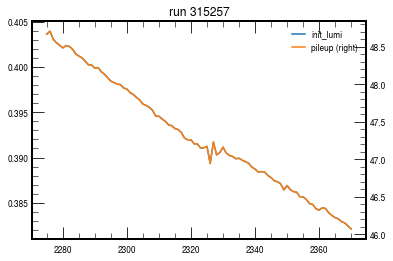

In [58]:
lumi_info = lscollgood_df[['run_number','init_lumi', 'end_lumi',
                 'pileup',
                 'recorded_lumi', 'delivered_lumi',
                 'lumisection_number',]]
run = 315257
lumi_info = lumi_info[lumi_info['run_number'] == run]
lumi_info.plot(y=['init_lumi', 'pileup'], secondary_y="pileup")
# plt.yscale("log")
plt.title("run {}".format(run))
plt.plot()

In [59]:
ls_df.index

MultiIndex([(315190,   1),
            (315190,   2),
            (315190,   3),
            (315190,   4),
            (315190,   5),
            (315190,   6),
            (315190,   7),
            (315190,   8),
            (315190,   9),
            (315190,  10),
            ...
            (316201, 498),
            (316201, 499),
            (316201, 500),
            (316201, 501),
            (316201, 502),
            (316201, 503),
            (316201, 504),
            (316201, 505),
            (316201, 506),
            (316201, 507)],
           names=['run_number', 'lumisection_number'], length=62469)

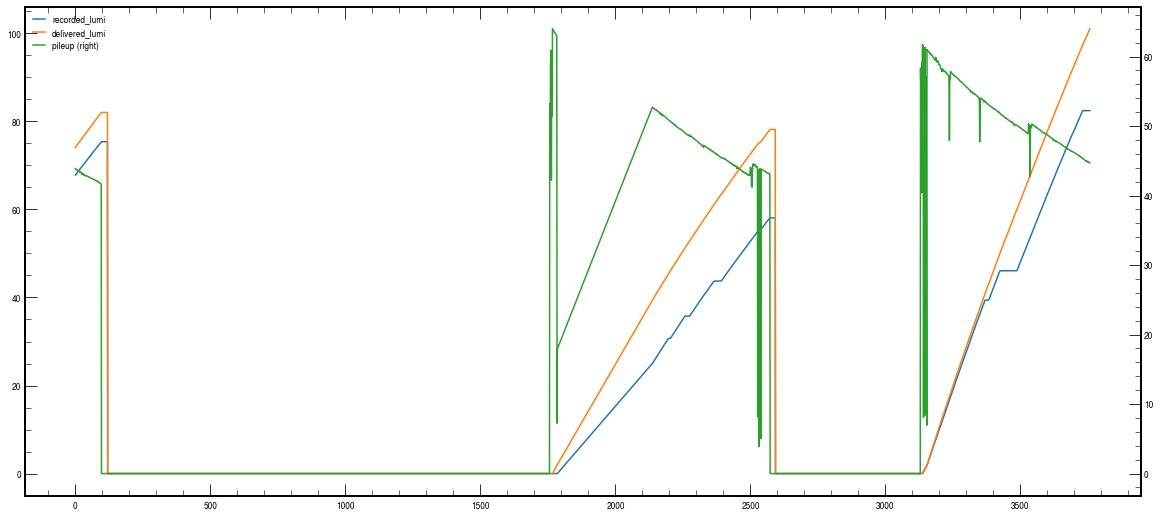

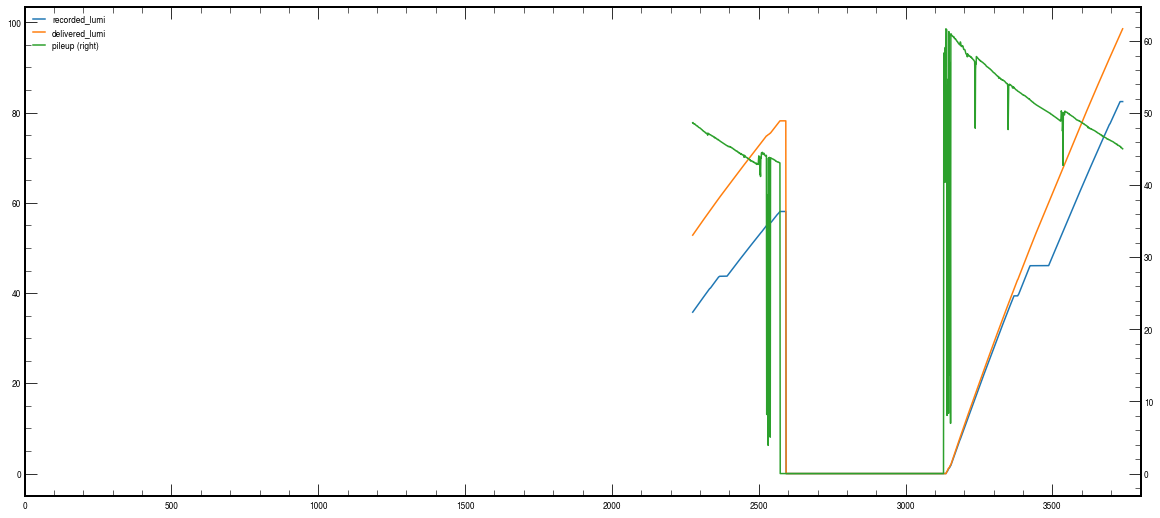

In [102]:

lscoll_df[lscoll_df['run_number'] < 315270].plot(y=['recorded_lumi','delivered_lumi','pileup'],style='-',figsize=(20,9),logy=False,logx=False,secondary_y="pileup")
lscollgood_df[lscollgood_df['run_number'] < 315270].plot(y=['recorded_lumi','delivered_lumi','pileup'],style='-',figsize=(20,9),logy=False,logx=False,secondary_y="pileup")
plt.xlim((0,3800))
plt.show()
# lsdf_collisions.plot(y=['init_lumi','end_lumi'],x='run_number' ,figsize=(19,9),logy=False,logx=False)

In [66]:
lscollgood_df['run_number'].unique()

<IntegerArray>
[315257, 315259, 315264, 315265, 315267, 315270, 315322, 315339, 315357,
 315361, 315363, 315365, 315366, 315420, 315488, 315489, 315490, 315506,
 315509, 315510, 315512, 315543, 315555, 315556, 315557, 315640, 315641,
 315642, 315644, 315645, 315646, 315647, 315648, 315689, 315690, 315702,
 315703, 315704, 315705, 315713, 315721, 315741, 315764, 315770, 315784,
 315785, 315786, 315790, 315800, 315801, 315840, 315973, 315974, 316058,
 316059, 316060, 316061, 316062, 316082, 316110, 316111, 316113, 316114,
 316151, 316153, 316186, 316187, 316199, 316200, 316201]
Length: 70, dtype: Int64

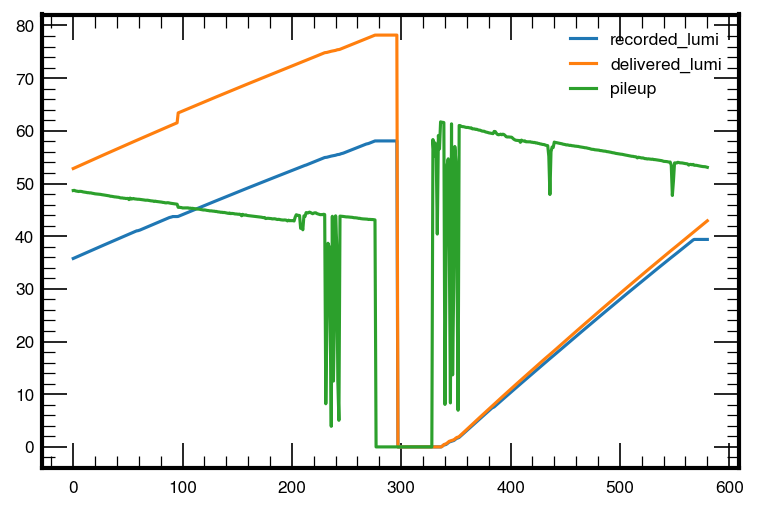

In [88]:
fig, ax = plt.subplots(dpi=150)
lscollgood_df[lscollgood_df['run_number'] <= 315264].reset_index().plot(y=['recorded_lumi', 'delivered_lumi', 'pileup'], ax=ax)

plt.show()

In [94]:
lscollgood_df[lscollgood_df['run_number'] == 315259][['recorded_lumi', 'delivered_lumi', 'pileup']]

,recorded_lumi,delivered_lumi,pileup
2392,43.756211,63.404914,45.476368
2393,43.842375,63.492762,45.478905
2394,43.928535,63.580605,45.451252
2395,44.014684,63.668406,45.430698
2396,44.100777,63.756141,45.360451
...,...,...,...
2600,0.0,0.0,0.0
2601,0.0,0.0,0.0
2602,0.0,0.0,0.0
2603,0.0,0.0,0.0


In [78]:
lscollgood_df[lscollgood_df['run_number'] <= 315265].reset_index()

,index,run_number,lumisection_number,fill_number,beam1_present,physics_flag,tecp_ready,bpix_ready,tecm_ready,cms_active,...,beam1_stable,tob_ready,init_lumi,pileup,recorded_lumi,delivered_lumi,beam2_stable,end_lumi,beam2_present,Fill location
0,2275,315257,1,6615,True,True,True,True,True,True,...,True,True,0.403637,48.668243,35.768637,52.84068,True,0.403952,True,(2155/2464)
1,2276,315257,2,6615,True,True,True,True,True,True,...,True,True,0.403952,48.706249,35.860723,52.934684,True,0.403063,True,(2156/2464)
2,2277,315257,3,6615,True,True,True,True,True,True,...,True,True,0.403063,48.599079,35.952852,53.028695,True,0.402681,True,(2157/2464)
3,2278,315257,4,6615,True,True,True,True,True,True,...,True,True,0.402681,48.552979,36.044766,53.12248,True,0.402396,True,(2158/2464)
4,2279,315257,5,6615,True,True,True,True,True,True,...,True,True,0.402396,48.518646,36.136641,53.216262,True,0.402111,True,(2159/2464)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639,3440,315265,59,6616,True,True,True,True,True,False,...,True,True,0.701903,51.318172,46.065547,52.63818,True,0.701506,True,(856/1893)
640,3441,315265,60,6616,True,True,True,True,True,False,...,True,True,0.701506,51.289143,46.065547,52.80168,True,0.700857,True,(857/1893)
641,3442,315265,61,6616,True,True,True,True,True,False,...,True,True,0.700857,51.241714,46.065547,52.965051,True,0.700539,True,(858/1893)
642,3443,315265,62,6616,True,True,True,True,True,False,...,True,True,0.700539,51.218422,46.065547,53.128316,True,0.699951,True,(859/1893)


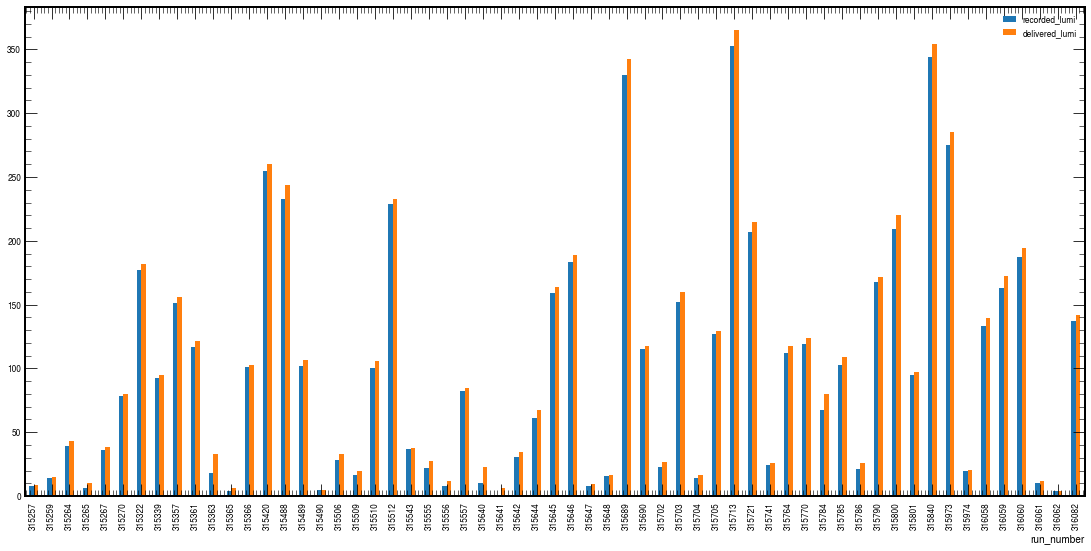

In [110]:
runcollgood_df.plot(y=['recorded_lumi',"delivered_lumi"], x="run_number",
                kind="bar", figsize=(19,9), logy=False, logx=False);

<h2>Cosmics</h2>

Will not be done for now. Focus is on collisions.

<h1><font color='blue'> Testing Ranking Systems </font></h1>

In [104]:
pd.options.mode.chained_assignment = None

<h2> Pre-existing RRR systems </h2>

The implementations previously developed used a dictionary as input where the elements of the dictionary were the run and LS dataframes. Therefore, we create such a dictionary.

In [89]:
# Making the dictionary out of dataframes
data_dict = {'runs': runcollgood_df.reset_index(), 'lumisections': lscollgood_df.reset_index()}

In [22]:
# # Run we wish to certify and for which we will find a correspond reference run
# target = 316201
# oldest_run = target - 1011

# # Range of runs of interest
# run_range = (oldest_run, target)
# print(run_range)

We also fetch the actual RR used for the certification of the target run.

In [118]:
targetRR = RRfetch(target, jsonfile='/eos/user/r/rcruzcan/SWAN_projects/RefRunRank/utils/json_allRunsRefRuns.json')
print('Actual RR used: ' + str(targetRR))

Actual RR used: 315713


<h3> Version 1 </h3>
Version 1 of the RRR system gives a rank to each of the runs given by the following equation. (Note: In the original proposed version 1, the equation is slighly altered. The equation shown here is the one found in the actual implementation.)

$$
    G_1 = 0.5 *(\text{inst lumi delta }\%)  + 0.25 *(\text{pileup delta }\%) + 0.25 *(\text{run number delta } \%)
$$

where
- $\text{quantity %} = \frac{\text{possible ref quantity}-\text{target quantity}}{\text{target quantity}} * 100$

In [92]:
v1_ranking = omsu.ref_rank(data_dict, target, Trim=False, ver='V1').set_index('run_number') \
    .sort_values(by=["Run_Rank","inst_lumi_delta %",'pileup_delta %','run_number_delta'], key=lambda x: x.abs(), ascending=True)
v1_ranking.reset_index(inplace=True)
v1_ranking

Target run : 316201
Fill location : (5/5)
Fill number : 6675.0
average pileup : 26.850620010157794
last lumi : 498.0
avg inst lumi : 0.9598289314828067
L1 HLT mode : collisions2018


,run_number,index,Unnamed: 0,components,init_lumi,recorded_lumi,delivered_lumi,energy,end_lumi,hlt_physics_rate,...,run_number_delta %,ave_pileup,pileup_delta,pileup_delta %,number_of_lumisections_delta,num_lumi_delta %,ave_inst_lumi,inst_lumi_delta,inst_lumi_delta %,Run_Rank
0,315512,138,204,"['CSC', 'CTPPS', 'CTPPS_TOT', 'DAQ', 'DCS', 'D...",1.183703,228.731453,233.006609,6499.0,1.728800e-08,1008.994,...,-0.217899,32.637014,5.786394,21.550319,629.0,126.305221,0.859293,-0.100536,-10.474342,0.000959
1,315365,90,122,"['CSC', 'CTPPS', 'CTPPS_TOT', 'DAQ', 'DCS', 'D...",0.716556,3.987266,6.243109,6499.0,7.022881e-01,1189.630,...,-0.264389,41.530845,14.680225,54.67369,-473.0,-94.979920,0.708733,-0.251096,-26.160495,0.005221
2,315363,89,121,"['CSC', 'CTPPS', 'CTPPS_TOT', 'DAQ', 'DCS', 'D...",0.743365,18.438914,32.609500,6499.0,7.166979e-01,802.599,...,-0.265021,41.864727,15.014107,55.917169,-362.0,-72.690763,0.714431,-0.245398,-25.566872,0.011296
3,315543,147,228,"['CSC', 'CTPPS', 'CTPPS_TOT', 'DAQ', 'DCS', 'D...",1.534642,36.726398,37.941371,6499.0,3.457700e-08,1119.570,...,-0.208095,33.223702,6.373082,23.735325,-318.0,-63.855422,0.874740,-0.085089,-8.865017,0.014493
4,315339,70,101,"['CSC', 'CTPPS', 'DAQ', 'DCS', 'DQM', 'DT', 'E...",0.783583,92.487602,95.110648,6499.0,5.718616e-01,824.899,...,-0.272611,43.829239,16.978619,63.233619,164.0,32.931727,0.600090,-0.359739,-37.479534,-0.029995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,315784,253,378,"['CSC', 'CTPPS', 'CTPPS_TOT', 'DAQ', 'DCS', 'D...",1.910669,67.614078,79.855625,6499.0,1.679284e+00,1505.472,...,-0.131878,44.505144,17.654524,65.750897,-298.0,-59.839357,1.590925,0.631096,65.750898,0.492802
65,315506,135,200,"['CSC', 'CTPPS', 'CTPPS_TOT', 'DAQ', 'DCS', 'D...",1.597696,28.227887,33.255820,6499.0,1.430748e+00,1537.530,...,-0.219797,54.366456,27.515836,102.477469,-398.0,-79.919679,1.431403,0.471574,49.131065,0.5013
66,315556,155,236,"['CSC', 'CTPPS', 'CTPPS_TOT', 'DAQ', 'DCS', 'D...",1.470127,8.151873,12.096621,6499.0,1.420706e+00,1641.218,...,-0.203984,54.782851,27.932231,104.028253,-472.0,-94.779116,1.442366,0.482537,50.273267,0.510927
67,316110,382,592,"['CSC', 'CTPPS', 'CTPPS_TOT', 'DAQ', 'DCS', 'D...",1.768108,78.897739,83.724470,6499.0,1.547745e+00,1333.360,...,-0.028779,46.577338,19.726718,73.468388,-288.0,-57.831325,1.665000,0.705171,73.468388,0.550941


We now evaluate how well this ranking system is by checking which run was actually used as reference.

In [51]:
print('Ranking of actual RR used for target:', list(np.where(v1_ranking['run_number'] == targetRR))[0][0])

Ranking of actual RR used for target: 42


<h3> Version 2 </h3>
The equation used in this version to compute the ranking is given by
$$
    G_2 = 0.5 * \frac{\text{(inst lumi %)} * \text{(run inst lumi)}}{100 * \text{(ave inst lumi)}} + 0.25 * \frac{\text{(pileup %)}}{\text{(run pileup)}} + 0.25 * \frac{\text{(run number %)}}{\text{(run num)}}
$$

In [52]:
v2_ranking = omsu.ref_rank(data_dict, target, Trim=False, ver='V2').set_index('run_number') \
    .sort_values(by=["Run_Rank","inst_lumi_delta %",'pileup_delta %','run_number_delta'], key=lambda x: x.abs(), ascending=True)
v2_ranking.reset_index(inplace=True)
v2_ranking

Target run : 316201
Fill location : (5/5)
Fill number : 6675.0
average pileup : 26.90716320634538
last lumi : 498.0
avg inst lumi : 0.9618501808014538
L1 HLT mode : collisions2018


In [53]:
print('Ranking of actual RR used for target:', list(np.where(v2_ranking['run_number'] == targetRR))[0][0])

Ranking of actual RR used for target: 29


<h3> Version 3 </h3>
The equation used for this version is given by
$$
    G_3 = \frac{\text{inst lumi delta %}}{100} + \frac{\text{pileup delta %}}{100} + \frac{\text{run num delta}}{100} + \frac{\text{num of lumi delta %}}{100}
$$

In [54]:
v3_ranking = omsu.ref_rank(data_dict, target, Trim=False, ver='V3').set_index('run_number') \
    .sort_values(by=["Run_Rank","inst_lumi_delta %",'pileup_delta %','run_number_delta'], key=lambda x: x.abs(), ascending=True)
v3_ranking.reset_index(inplace=True)
v3_ranking

Target run : 316201
Fill location : (5/5)
Fill number : 6675.0
average pileup : 26.90716320634538
last lumi : 498.0
avg inst lumi : 0.9618501808014538
L1 HLT mode : collisions2018


,run_number,index,Unnamed: 0,components,init_lumi,recorded_lumi,delivered_lumi,energy,end_lumi,hlt_physics_rate,...,run_number_delta %,ave_pileup,pileup_delta,pileup_delta %,number_of_lumisections_delta,num_lumi_delta %,ave_inst_lumi,inst_lumi_delta,inst_lumi_delta %,Run_Rank
0,315690,204,323,"['CSC', 'CTPPS', 'CTPPS_TOT', 'DAQ', 'DCS', 'D...",0.893965,115.517906,117.609875,6499.0,7.339086e-01,760.945,...,-0.161606,23.783896,-3.123268,-11.607569,168.0,33.734940,0.770632,-0.191218,-19.880239,0.972227
1,315489,129,194,"['CSC', 'CTPPS', 'CTPPS_TOT', 'DAQ', 'DCS', 'D...",0.731744,102.089141,106.610031,6499.0,1.831568e-01,704.796,...,-0.225173,29.181821,2.274658,8.453728,211.0,42.369478,0.630492,-0.331358,-34.450107,0.992733
2,315703,212,331,"['CSC', 'CTPPS', 'CTPPS_TOT', 'DAQ', 'DCS', 'D...",1.392372,152.237340,159.696533,6499.0,1.042650e+00,1181.103,...,-0.157495,36.063432,9.156269,34.029113,47.0,9.437751,1.240493,0.278642,28.969422,1.064363
3,315705,214,333,"['CSC', 'CTPPS', 'CTPPS_TOT', 'DAQ', 'DCS', 'D...",0.999135,127.170766,129.466625,6499.0,6.307170e-01,747.150,...,-0.156862,22.955332,-3.951832,-14.686913,212.0,42.570281,0.789606,-0.172244,-17.907540,1.111647
4,315645,187,290,"['CSC', 'CTPPS', 'CTPPS_TOT', 'DAQ', 'DCS', 'D...",1.371322,158.760711,164.031578,6499.0,9.930910e-01,1174.535,...,-0.175838,38.664877,11.757714,43.697337,96.0,19.277108,1.174531,0.212681,22.111658,1.120861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,315741,232,352,"['CSC', 'CTPPS', 'CTPPS_TOT', 'DAQ', 'DCS', 'D...",2.086029,24.312406,26.027680,6499.0,1.728800e-08,1137.968,...,-0.145477,49.910242,23.003079,85.490541,-399.0,-80.120482,1.784141,0.822291,85.490540,2.901016
62,316114,386,596,"['CSC', 'CTPPS', 'CTPPS_TOT', 'DAQ', 'DCS', 'D...",1.404032,351.324750,360.699203,6499.0,6.318345e-01,782.970,...,-0.027514,27.531499,0.624336,2.320332,1151.0,231.124498,0.984168,0.022318,2.320332,2.957652
63,316199,409,650,"['CSC', 'CTPPS', 'CTPPS_TOT', 'DAQ', 'DCS', 'D...",2.044305,388.417500,403.394875,6499.0,1.092212e+00,1171.792,...,-0.000633,41.393053,14.48589,53.836556,699.0,140.361446,1.479677,0.517827,53.836556,3.120346
64,315420,112,161,"['CSC', 'CTPPS', 'CTPPS_TOT', 'DAQ', 'DCS', 'D...",0.995317,254.577000,260.383281,6499.0,4.690041e-01,794.405,...,-0.246995,37.920828,11.013665,40.932093,1259.0,252.811245,0.647127,-0.314723,-32.720582,3.384639


In [55]:
print('Ranking of actual RR used for target:', list(np.where(v3_ranking['run_number'] == targetRR))[0][0])

Ranking of actual RR used for target: 55


<h1> <font color='blue'> Developing a New Approach </font> </h1>

Taking a look at the available features in our data.

In [112]:
runcollgood_df.iloc[0]

run_number                                                            315257
components                 [CSC, CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECA...
init_lumi                                                           0.403637
recorded_lumi                                                       7.958398
delivered_lumi                                                      8.684852
energy                                                                  6499
end_lumi                                                            0.382113
hlt_physics_rate                                                     715.162
fill_number                                                             6615
l1_hlt_mode                                                   collisions2018
end_time                                                2018-04-26T21:45:02Z
trigger_mode                                       l1_hlt_collisions2018/v73
l1_key_stripped                                           collisions2018/v10

In [113]:
lscollgood_df.iloc[0]

run_number                 315257
lumisection_number              1
fill_number                  6615
beam1_present                True
physics_flag                 True
tecp_ready                   True
bpix_ready                   True
tecm_ready                   True
cms_active                   True
tibtid_ready                 True
fpix_ready                   True
beam1_stable                 True
tob_ready                    True
init_lumi                0.403637
pileup                  48.668243
recorded_lumi           35.768637
delivered_lumi           52.84068
beam2_stable                 True
end_lumi                 0.403952
beam2_present                True
Fill location         (2155/2464)
Name: 48553, dtype: object

<h2><font color='green'>Run level features</font></h2> 

We create dataframes which will contain only the features we wish to consider in our run ranking algorithm. Starting with run level data, we will consider 
- `init_lumi`
- `end_lumi`
- `delta_lumi` (change in lumi, computed)
- `delivered_lumi`
- `temp_dist` (how far back in time a run with respect to target run)
- `run_number`

We also get `duration`, which will be the length in seconds of the run itself. Recall that our target run here is `316201`.

In [114]:
# runfeatures = ['run_number', 'init_lumi', 'end_lumi', 'delivered_lumi', 'start_time', 'end_time']
# runs = runcollgood_df[runfeatures].copy(deep=True)

In [105]:
# Converting to time type
runcollgood_df['start_time'] = pd.to_datetime(runcollgood_df['start_time'])
runcollgood_df['end_time'] = pd.to_datetime(runcollgood_df['end_time'])

# Getting temporal distance
target_time = runcollgood_df[runcollgood_df['run_number']==target]['start_time'].item() # Target not in runcollgood df
runcollgood_df['temp_dist'] = (target_time - runcollgood_df['start_time']).dt.total_seconds().abs()

# Getting total change in lumi
runcollgood_df['delta_totallumi'] = runcollgood_df['end_lumi'] - runcollgood_df['init_lumi']

# Getting duration
runcollgood_df['duration'] = (runcollgood_df['end_time'] - runcollgood_df['start_time']).dt.total_seconds()

# Dropping start and end times
# runs.drop(['start_time', 'end_time'], axis=1, inplace=True)

In [107]:
runcollgood_df[runcollgood_df['run_number'] == target]

,run_number,components,init_lumi,recorded_lumi,delivered_lumi,energy,end_lumi,hlt_physics_rate,fill_number,l1_hlt_mode,...,fill_type_runtime,last_lumisection_number,l1_rate,l1_menu,stable_beam,hlt_physics_counter,Fill location,temp_dist,delta_totallumi,duration
411,316201,"[CSC, CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECA...",1.080307,105.893094,113.155281,6499,0.846014,793.303,6675,collisions2018,...,PROTONS,498,60138.6,L1Menu_Collisions2018_v1_0_0,True,9079675,(5/5),0.0,-0.234293,11652.0


In [108]:
runcollgood_df['duration']

37      2173.0
39      4324.0
42      6119.0
43      1389.0
45      5716.0
        ...   
405     1916.0
406    48456.0
409    27932.0
410      286.0
411    11652.0
Name: duration, Length: 70, dtype: float64

In the end, all the run level features we will consider are:

In [109]:
runfeaturelst = [
    'run_number',
    'temp_dist',
    'init_lumi',
    'end_lumi',
    'delta_totallumi',
    'delivered_lumi'
]

In [110]:
run_features = runcollgood_df[runfeaturelst]
run_features

,run_number,temp_dist,init_lumi,end_lumi,delta_totallumi,delivered_lumi
37,315257,1402011.0,0.403637,0.382113,-0.021524,8.684852
39,315259,1399304.0,0.377165,0.357424,-0.019741,14.76875
42,315264,1382578.0,0.84294,0.725879,-0.117061,42.924551
43,315265,1376260.0,0.725641,0.699951,-0.02569,10.303512
45,315267,1373831.0,0.685031,0.616229,-0.068803,38.581152
...,...,...,...,...,...,...
405,316186,85830.0,1.913131,1.789848,-0.123283,18.344252
406,316187,83872.0,1.788128,0.680513,-1.107615,535.870717
409,316199,28422.0,2.044305,1.092212,-0.952093,403.394875
410,316200,447.0,1.047794,1.081414,0.03362,4.554625


In [111]:
def get_weights(df, standardize=True, plot=False):
    '''
    Gets weights
    '''
    if standardize:
        scaler = StandardScaler()
        df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    if plot:
        sns.pairplot(df)
        plt.show()
    pca = PCA()
    pca.fit(df)
    pc1_loadings = pca.components_[0]
    pc1_df = pd.DataFrame(pc1_loadings, index=df.columns, columns=['PC1 Loadings'])
    pc1_df['weights'] = pc1_df['PC1 Loadings'] ** 2 # Already normalized
    
    return pc1_df['weights'].to_numpy()

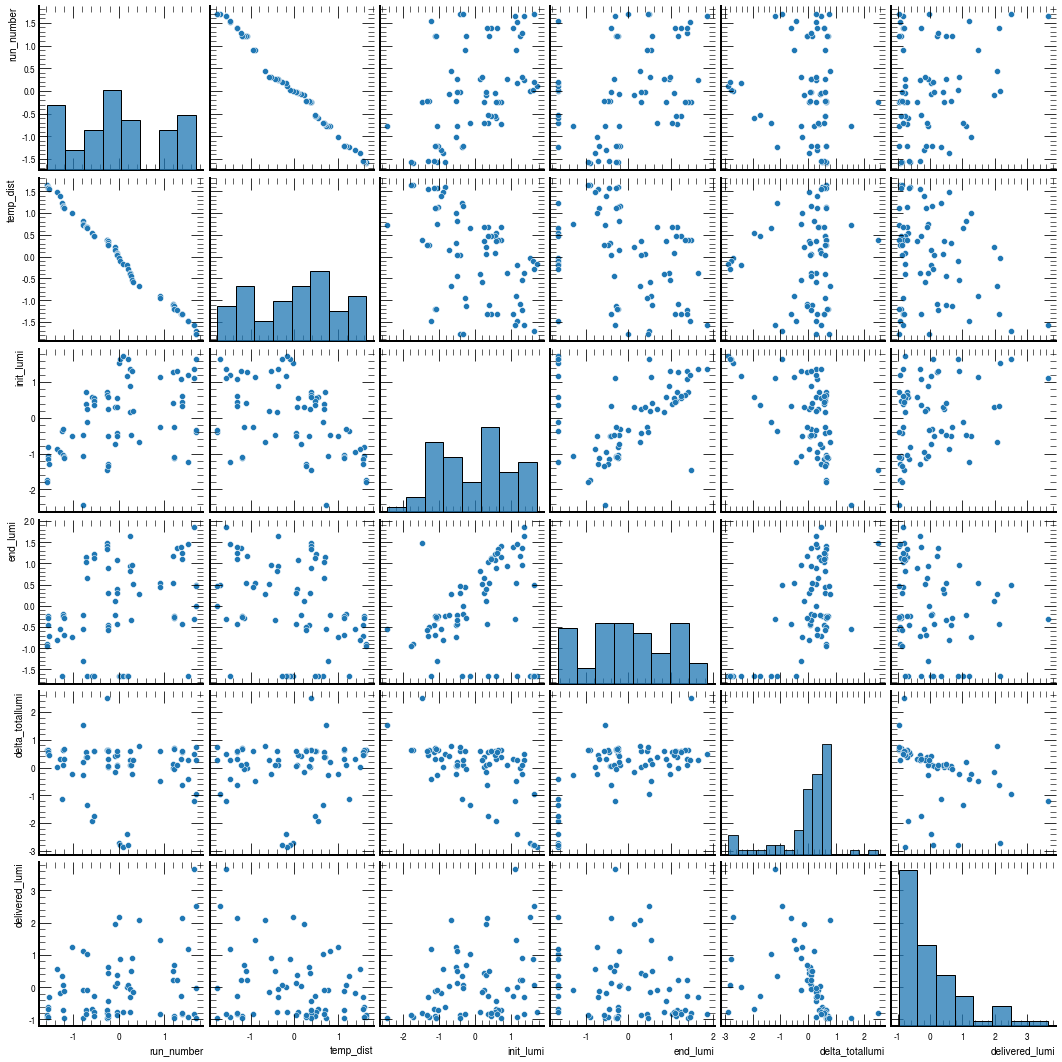

In [112]:
weights = get_weights(run_features, plot=True)

In [113]:
print('Run level feature weights: ')
{feature: weight for feature, weight in zip(runfeaturelst, weights)}

Run level feature weights: 


{'run_number': 0.30481692077394246,
 'temp_dist': 0.30685661455050606,
 'init_lumi': 0.22185700053982796,
 'end_lumi': 0.03616323994696966,
 'delta_totallumi': 0.05071495741071882,
 'delivered_lumi': 0.07959126677803428}

Notice that besides `run_number` and `temp_dist`, `init_lumi` is a very important feature.

It's clear that `run_number` and `temp_dist` are of equal importance. We can try dropping `temp_dist` and get the weight to see what this gives us.

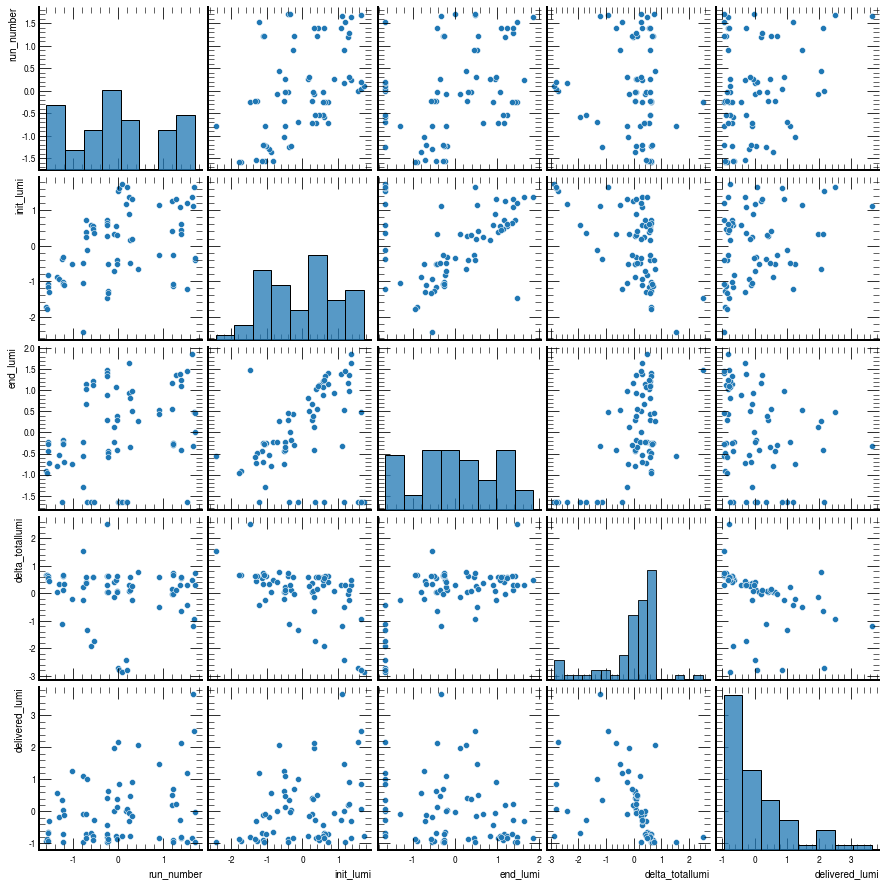

Run level feature weights: 


{'run_number': 0.10820900557755463,
 'init_lumi': 0.26823552529153494,
 'end_lumi': 0.03442361341810039,
 'delta_totallumi': 0.34848849707978813,
 'delivered_lumi': 0.2406433586330211}

In [117]:
weights2 = get_weights(run_features[['run_number', 'init_lumi', 'end_lumi', 'delta_totallumi' ,'delivered_lumi']], plot=True)
print('Run level feature weights: ')
{feature: weight for feature, weight in zip(['run_number', 'init_lumi', 'end_lumi', 'delta_totallumi' ,'delivered_lumi'], weights2)}

We can also try without run number or temporal distance to see the weights of the other parameters.

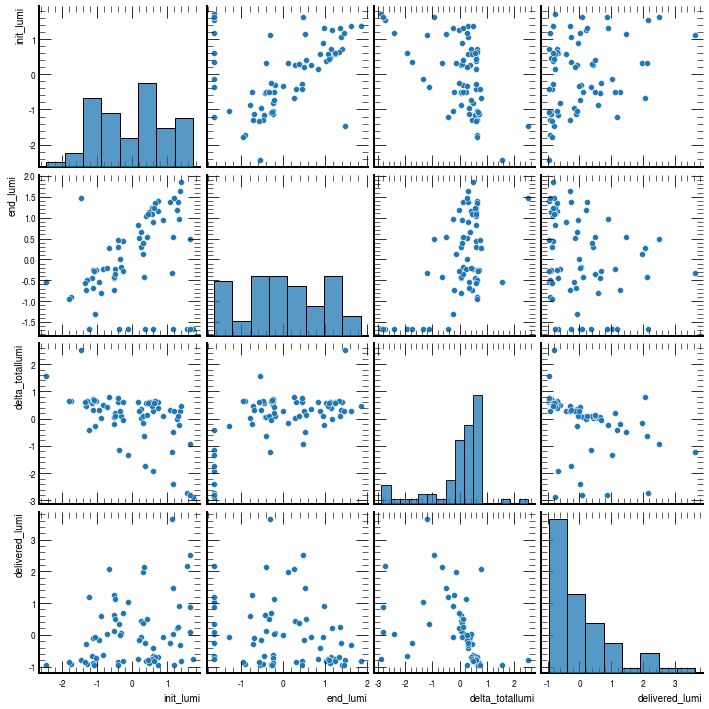

Run level feature weights: 


{'init_lumi': 0.14859175400212046,
 'end_lumi': 0.16105971977311934,
 'delta_totallumi': 0.4461781782132058,
 'delivered_lumi': 0.24417034801155355}

In [118]:
weights3 = get_weights(run_features[['init_lumi', 'end_lumi', 'delta_totallumi' ,'delivered_lumi']], plot=True)
print('Run level feature weights: ')
{feature: weight for feature, weight in zip(['init_lumi', 'end_lumi', 'delta_totallumi' ,'delivered_lumi'], weights3)}

<h2><font color='green'>Extra: Studying relationship between temporal distance and run number</font></h2>

Ranking system should favor:
- Longer runs
- Runs which are as similar as possible to the target run, this includes consideration of the temporal distance

Note that in addition to historical time, run # gives a measure time which contains information of the change of data-taking conditions. However, the length of particular run can vary considerably. We quickly visualize this latter fact.

In [44]:
runs['start_time'] = pd.to_datetime(runs['start_time'])
runs['end_time'] = pd.to_datetime(runs['end_time'])
runs['duration'] = runs['end_time'] - runs['start_time']

runs = runs.sort_values('start_time').reset_index()

In [96]:
runs['duration'].iloc[0]

Timedelta('0 days 00:36:13')

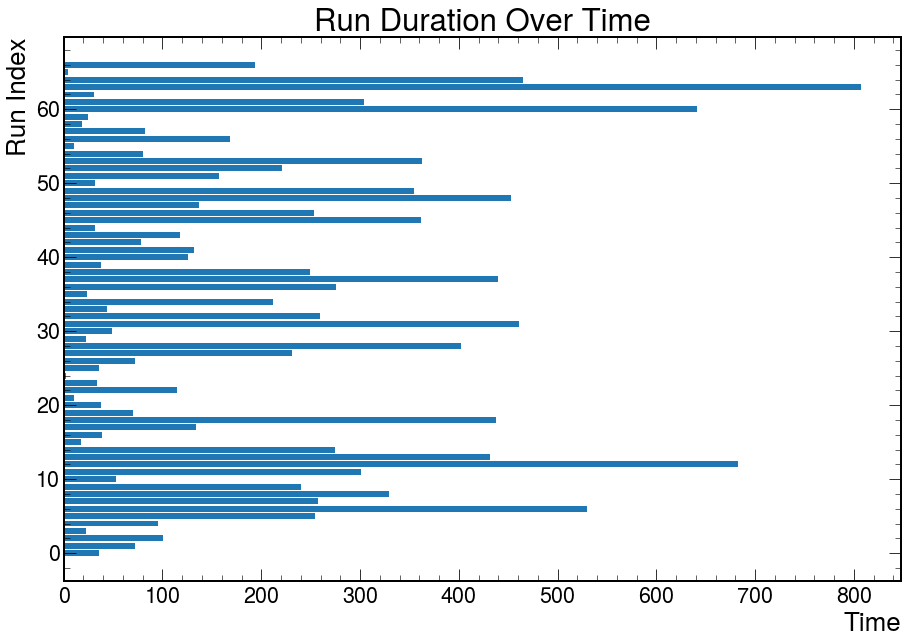

In [105]:
plt.figure(figsize=(15,10))

plt.barh(runs.index, runs['duration'].astype('timedelta64[m]'))
plt.xlabel('Time')
plt.ylabel('Run Index')
plt.title('Run Duration Over Time')

plt.show()

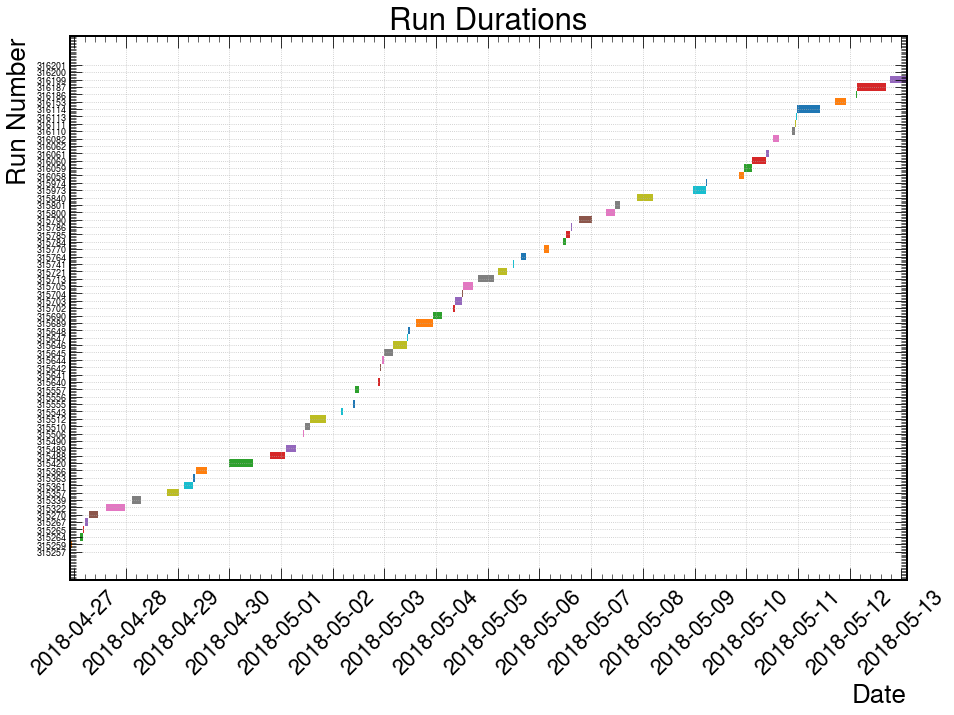

In [121]:
runs['y_pos'] = range(len(runs))


# Plotting
fig, ax = plt.subplots(figsize=(15, 10))

# Loop over rows in the run dataframe
for idx, row in runs.iterrows():
    ax.barh(y=row['y_pos'], # 
            width=(row['end_time'] - row['start_time']).total_seconds() / 86400.0,  # Setting width to be the duration. (divided by 86400 to conver to days)
            left=row['start_time'], # where the bar starts; starts at the point where the time starts
            height=1) # height of bar

# Set y labels and ticks
ax.set_yticks(runs['y_pos'])
ax.set_yticklabels(runs['run_number'], fontsize=9)

# Set x as time as time axis, and set time label
ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

# Labels and Title
plt.xlabel('Date')
plt.ylabel('Run Number')
plt.title('Run Durations')

# Grid
plt.grid(True)

plt.show()

# Drop the new column which is not useful except for making this plot
runs.drop(columns='y_pos', inplace=True)

<h2><font color='green'>LS level features</font></h2> 

Features of interest from LS data:
- average and std of `init_lumi`
- average and std of `end_lumi`
- average and std of `pile_up`

In [119]:
lscollgood_df.keys()

Index(['run_number', 'lumisection_number', 'fill_number', 'beam1_present',
       'physics_flag', 'tecp_ready', 'bpix_ready', 'tecm_ready', 'cms_active',
       'tibtid_ready', 'fpix_ready', 'beam1_stable', 'tob_ready', 'init_lumi',
       'pileup', 'recorded_lumi', 'delivered_lumi', 'beam2_stable', 'end_lumi',
       'beam2_present', 'Fill location'],
      dtype='object')

In [120]:
lsfeaturelst = [
    'run_number', 
    'lumisection_number',
    'init_lumi', 
    'end_lumi', 
    'pileup'
]

In [121]:
lss = lscollgood_df[lsfeaturelst]
lss

,run_number,lumisection_number,init_lumi,end_lumi,pileup
2275,315257,1,0.403637,0.403952,48.668243
2276,315257,2,0.403952,0.403063,48.706249
2277,315257,3,0.403063,0.402681,48.599079
2278,315257,4,0.402681,0.402396,48.552979
2279,315257,5,0.402396,0.402111,48.518646
...,...,...,...,...,...
62464,316201,503,0.848617,0.847091,23.739538
62465,316201,504,0.847091,0.847168,23.696846
62466,316201,505,0.847168,0.846586,23.698994
62467,316201,506,0.846586,0.846014,23.68272


In [122]:
names = ['init_lumi', 'end_lumi', 'pileup']
names = [name + suffix for suffix in ['_std', '_mean'] for name in names ]

lsstats_dict = {}
for run in lss['run_number'].unique():
    runlsstats = lss[lss['run_number']==run].describe()
    stds = runlsstats.loc['std'].to_list()[2:]
    means = runlsstats.loc['mean'].to_list()[2:]
    lsstats_dict[run] = {name: stat for name, stat in zip(names, stds+means)}    

In [123]:
ls_features = pd.DataFrame(lsstats_dict).T
ls_features

,init_lumi_std,end_lumi_std,pileup_std,init_lumi_mean,end_lumi_mean,pileup_mean
315257,0.006181,0.006162,0.745211,0.392431,0.392206,47.317126
315259,0.135696,0.137140,16.361486,0.300161,0.298390,36.191690
315264,0.219007,0.214783,16.012202,0.703657,0.706325,51.446401
315265,0.007638,0.007654,0.558451,0.713359,0.712954,52.155739
315267,0.021500,0.021580,1.571906,0.656939,0.656666,48.030736
...,...,...,...,...,...,...
316186,0.863855,0.858505,24.165809,1.097324,1.118611,30.696969
316187,0.439986,0.440175,12.308334,1.001787,1.001009,28.024362
316199,0.332333,0.329884,9.296820,1.452725,1.453598,40.639096
316200,0.009336,0.003437,0.261160,1.084049,1.085761,30.325614


In [124]:
features = pd.concat([run_features.set_index('run_number'), ls_features], axis=1).reset_index()
features.rename(columns = {'index':'run_number'}, inplace=True)
features

,run_number,temp_dist,init_lumi,end_lumi,delta_totallumi,delivered_lumi,init_lumi_std,end_lumi_std,pileup_std,init_lumi_mean,end_lumi_mean,pileup_mean
0,315257,1402011.0,0.403637,0.382113,-0.021524,8.684852,0.006181,0.006162,0.745211,0.392431,0.392206,47.317126
1,315259,1399304.0,0.377165,0.357424,-0.019741,14.76875,0.135696,0.137140,16.361486,0.300161,0.298390,36.191690
2,315264,1382578.0,0.84294,0.725879,-0.117061,42.924551,0.219007,0.214783,16.012202,0.703657,0.706325,51.446401
3,315265,1376260.0,0.725641,0.699951,-0.02569,10.303512,0.007638,0.007654,0.558451,0.713359,0.712954,52.155739
4,315267,1373831.0,0.685031,0.616229,-0.068803,38.581152,0.021500,0.021580,1.571906,0.656939,0.656666,48.030736
...,...,...,...,...,...,...,...,...,...,...,...,...
65,316186,85830.0,1.913131,1.789848,-0.123283,18.344252,0.863855,0.858505,24.165809,1.097324,1.118611,30.696969
66,316187,83872.0,1.788128,0.680513,-1.107615,535.870717,0.439986,0.440175,12.308334,1.001787,1.001009,28.024362
67,316199,28422.0,2.044305,1.092212,-0.952093,403.394875,0.332333,0.329884,9.296820,1.452725,1.453598,40.639096
68,316200,447.0,1.047794,1.081414,0.03362,4.554625,0.009336,0.003437,0.261160,1.084049,1.085761,30.325614


In [125]:
features.columns.to_list()

['run_number',
 'temp_dist',
 'init_lumi',
 'end_lumi',
 'delta_totallumi',
 'delivered_lumi',
 'init_lumi_std',
 'end_lumi_std',
 'pileup_std',
 'init_lumi_mean',
 'end_lumi_mean',
 'pileup_mean']

In [126]:
weights3 = get_weights(features)
print('Fevel feature weights: ')
{feature: weight for feature, weight in zip(features.columns.to_list(), weights3)}

Fevel feature weights: 


{'run_number': 0.10279893791652836,
 'temp_dist': 0.10496864304471054,
 'init_lumi': 0.1749061873618416,
 'end_lumi': 0.016643321860343226,
 'delta_totallumi': 0.055015454051931645,
 'delivered_lumi': 0.029347342389321126,
 'init_lumi_std': 0.10366966828770428,
 'end_lumi_std': 0.1030788868458893,
 'pileup_std': 0.04958170362586782,
 'init_lumi_mean': 0.12879579672633995,
 'end_lumi_mean': 0.1294124918460016,
 'pileup_mean': 0.001781566043519959}

In [139]:
# Without run number and temporal distance
weights3 = get_weights(features[[
    'init_lumi', 
    'end_lumi', 
    'delta_totallumi', 
    'delivered_lumi', 
    'init_lumi_std', 
    'end_lumi_std',
    'pileup_std',
    'init_lumi_mean',
    'end_lumi_mean',
    'pileup_mean'
]])
print('Feature weights: ')
{feature: weight for feature, weight in zip(features[[
    'init_lumi', 
    'end_lumi', 
    'delta_totallumi', 
    'delivered_lumi', 
    'init_lumi_std', 
    'end_lumi_std',
    'pileup_std',
    'init_lumi_mean',
    'end_lumi_mean',
    'pileup_mean'
]].columns.to_list(), weights3)}

Feature weights: 


{'init_lumi': 0.19069851039712613,
 'end_lumi': 0.0022209833644621165,
 'delta_totallumi': 0.10302131349428308,
 'delivered_lumi': 0.03213213251179998,
 'init_lumi_std': 0.16257839968699137,
 'end_lumi_std': 0.16189315438587437,
 'pileup_std': 0.11123664654860999,
 'init_lumi_mean': 0.11242501600179453,
 'end_lumi_mean': 0.11333121052849135,
 'pileup_mean': 0.010462633080567314}

- Features of importance after testing different combinations:
    - `run_number`
    - `temp_dist`
    - `init_lumi`
    - `end_lumi`
    - `init_lumi_mean`
    - `end_lumi_mean`
- Including features related to the standard deviation of a LS-lel quantity worsened the performance of the ranking considerably.
- Including `pileup_mean`, `delta_totallumi` and/or `delivered_lumi` make the ranking performance worse, but not by much if only one of these are included at a time.

In [140]:
features_to_use = ['run_number', 'temp_dist', 'init_lumi', 'end_lumi', 'init_lumi_mean', 'end_lumi_mean']

In [244]:
features.set_index('run_number').loc[:315267]

,temp_dist,init_lumi,end_lumi,delta_totallumi,delivered_lumi,init_lumi_std,end_lumi_std,pileup_std,init_lumi_mean,end_lumi_mean,pileup_mean
run_number,,,,,,,,,,,
315257,1402011.0,0.403637,0.382113,-0.021524,8.684852,0.006181,0.006162,0.745211,0.392431,0.392206,47.317126
315259,1399304.0,0.377165,0.357424,-0.019741,14.76875,0.135696,0.137140,16.361486,0.300161,0.298390,36.191690
315264,1382578.0,0.84294,0.725879,-0.117061,42.924551,0.219007,0.214783,16.012202,0.703657,0.706325,51.446401
315265,1376260.0,0.725641,0.699951,-0.02569,10.303512,0.007638,0.007654,0.558451,0.713359,0.712954,52.155739
315267,1373831.0,0.685031,0.616229,-0.068803,38.581152,0.021500,0.021580,1.571906,0.656939,0.656666,48.030736


<h2><font color='green'> Finding rank using PCA </font></h2>

As a first approach, we find the first $N$ principal components of the features, project the features in this reduced dimensionality space and find the Eucledian distance in this sub-space. We start with $N=1$.

In [317]:
importlib.reload(rrr)

<module 'refrank_utils' from '/eos/home-i02/r/rcruzcan/SWAN_projects/RefRunRank/utils/refrank_utils.py'>

In [287]:
# Features dataframe
features = pd.concat([run_features.set_index('run_number'), ls_features], axis=1).reset_index()
features.rename(columns = {'index':'run_number'}, inplace=True)
features

,run_number,temp_dist,init_lumi,end_lumi,delta_totallumi,delivered_lumi,init_lumi_std,end_lumi_std,pileup_std,init_lumi_mean,end_lumi_mean,pileup_mean
0,315257,1402011.0,0.403637,0.382113,-0.021524,8.684852,0.006181,0.006162,0.745211,0.392431,0.392206,47.317126
1,315259,1399304.0,0.377165,0.357424,-0.019741,14.76875,0.135696,0.137140,16.361486,0.300161,0.298390,36.191690
2,315264,1382578.0,0.84294,0.725879,-0.117061,42.924551,0.219007,0.214783,16.012202,0.703657,0.706325,51.446401
3,315265,1376260.0,0.725641,0.699951,-0.02569,10.303512,0.007638,0.007654,0.558451,0.713359,0.712954,52.155739
4,315267,1373831.0,0.685031,0.616229,-0.068803,38.581152,0.021500,0.021580,1.571906,0.656939,0.656666,48.030736
...,...,...,...,...,...,...,...,...,...,...,...,...
65,316186,85830.0,1.913131,1.789848,-0.123283,18.344252,0.863855,0.858505,24.165809,1.097324,1.118611,30.696969
66,316187,83872.0,1.788128,0.680513,-1.107615,535.870717,0.439986,0.440175,12.308334,1.001787,1.001009,28.024362
67,316199,28422.0,2.044305,1.092212,-0.952093,403.394875,0.332333,0.329884,9.296820,1.452725,1.453598,40.639096
68,316200,447.0,1.047794,1.081414,0.03362,4.554625,0.009336,0.003437,0.261160,1.084049,1.085761,30.325614


In [372]:
# Features that will be considered in the ranking
features_to_use = [
    'run_number', 
    'temp_dist', 
    'init_lumi', 
    'end_lumi',
#     'delta_totallumi', 
#     'delivered_lumi', 
#     'init_lumi_std',  #
#     'end_lumi_std',  #
#     'pileup_std',  #
    'init_lumi_mean',
    'end_lumi_mean',
#     'pileup_mean'  #
]

In [373]:
# Reformatting df for use in ranking
features['run'] = features['run_number']
features.set_index('run', inplace=True)
features

,run_number,temp_dist,init_lumi,end_lumi,delta_totallumi,delivered_lumi,init_lumi_std,end_lumi_std,pileup_std,init_lumi_mean,end_lumi_mean,pileup_mean
run,,,,,,,,,,,,
315257,315257,1402011.0,0.403637,0.382113,-0.021524,8.684852,0.006181,0.006162,0.745211,0.392431,0.392206,47.317126
315259,315259,1399304.0,0.377165,0.357424,-0.019741,14.76875,0.135696,0.137140,16.361486,0.300161,0.298390,36.191690
315264,315264,1382578.0,0.84294,0.725879,-0.117061,42.924551,0.219007,0.214783,16.012202,0.703657,0.706325,51.446401
315265,315265,1376260.0,0.725641,0.699951,-0.02569,10.303512,0.007638,0.007654,0.558451,0.713359,0.712954,52.155739
315267,315267,1373831.0,0.685031,0.616229,-0.068803,38.581152,0.021500,0.021580,1.571906,0.656939,0.656666,48.030736
...,...,...,...,...,...,...,...,...,...,...,...,...
316186,316186,85830.0,1.913131,1.789848,-0.123283,18.344252,0.863855,0.858505,24.165809,1.097324,1.118611,30.696969
316187,316187,83872.0,1.788128,0.680513,-1.107615,535.870717,0.439986,0.440175,12.308334,1.001787,1.001009,28.024362
316199,316199,28422.0,2.044305,1.092212,-0.952093,403.394875,0.332333,0.329884,9.296820,1.452725,1.453598,40.639096


In [374]:
# Initial test that ranking system actually ranks
target = 316201
targetRR = RRfetch(target, jsonfile='/eos/user/r/rcruzcan/SWAN_projects/RefRunRank/utils/json_allRunsRefRuns.json')
rankings = rrr.refrank_pca(features[features_to_use], target, n_components=1)
print('Ranking of RR used: ', rankings.index[rankings['run']==targetRR][0])
rankings

Ranking of RR used:  3


,run,dist,PC1
0,316201,0.000000,-1.037523
1,315721,0.028611,-1.008912
2,315506,0.037140,-1.074663
3,315713,0.048541,-0.988982
4,316153,0.066678,-0.970845
...,...,...,...
65,315322,3.928782,2.891259
66,315270,4.268064,3.230541
67,315490,4.688625,3.651102
68,315257,4.896604,3.859081


In [375]:
# Testing a case where there will not be enough candidate runs to apply ranking
target = 315257
targetRR = RRfetch(target, jsonfile='/eos/user/r/rcruzcan/SWAN_projects/RefRunRank/utils/json_allRunsRefRuns.json')
rankings = rrr.refrank_pca(features[features_to_use], target, n_components=1)
print(rankings)

ERROR: Not enough runs to perform ranking
None


count    36.000000
mean     16.250000
std      12.215622
min       1.000000
25%       7.000000
50%      15.500000
75%      20.250000
max      61.000000
Name: ActualRefRank, dtype: float64
Rank system efficiency:  0.3055555555555556


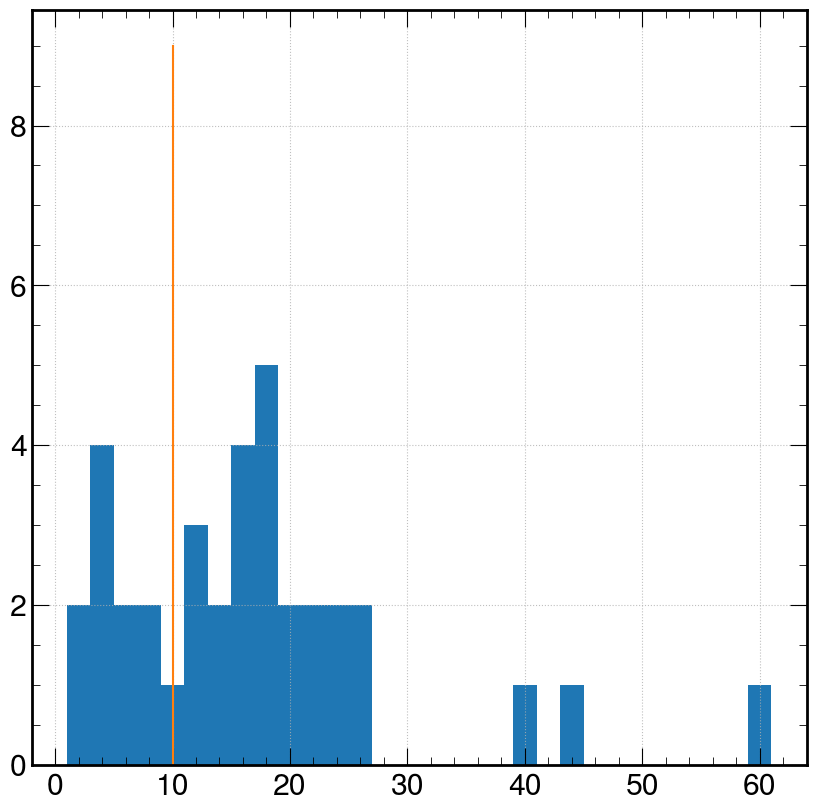

In [376]:
# Testing over many target runs to obtain better idea of performance
RRranks = []
results = {}

# Loop over some of the runs that are available
for targ in list(features.reset_index()['run'].unique())[34:]:
    # Get reference run
    targetRR = RRfetch(targ, jsonfile='/eos/user/r/rcruzcan/SWAN_projects/RefRunRank/utils/json_allRunsRefRuns.json')
    
    rankings = rrr.refrank_pca(features[features_to_use], targ, n_components=1)

    # In case there are any target runs for which the number of candidate runs is 0
    if rankings is None:
        pass
    
    # Get the rank the actual reference got
    actualrefrank = rankings.index[rankings['run']==targetRR][0]
    RRranks.append(actualrefrank)
    results[targ] = {'ActualRef': targetRR, 'ActualRefRank': actualrefrank}

results = pd.DataFrame(results).T
print(results['ActualRefRank'].describe())

ranksyseff = len(results[results['ActualRefRank'] <= 10])/len(results)
print('Rank system efficiency: ', ranksyseff)

fig, ax = plt.subplots(dpi=100)
ax = results['ActualRefRank'].hist(bins=30)

ax.plot([10]*10, range(0,10))

plt.show()

In [381]:
# Re-testing, but excluding runs that have low number of LSs
isrunlong = {}
for run in lss['run_number'].unique():
    run_length = len(lss[lss['run_number']==run])
    isrunlong[run] = run_length > 700

In [379]:
features_longruns = features.set_index('run_number')[pd.Series(isrunlong)].reset_index()
features_longruns

/tmp/ipykernel_551/2267363049.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  features_longruns = features.set_index('run_number')[pd.Series(isrunlong)].reset_index()


,run_number,temp_dist,init_lumi,end_lumi,delta_totallumi,delivered_lumi,init_lumi_std,end_lumi_std,pileup_std,init_lumi_mean,end_lumi_mean,pileup_mean
0,315322,1339405.0,0.817513,0.439283,-0.37823,181.673313,0.147793,0.147793,10.794447,0.566384,0.566384,41.367439
1,315357,1236043.0,1.065461,0.0,-1.065461,155.624266,0.250911,0.250912,14.703084,0.777918,0.777918,45.584998
2,315366,1187801.0,0.701719,0.489743,-0.211975,102.477984,0.145928,0.147100,8.551169,0.547938,0.547065,32.108484
3,315420,1133563.0,0.995317,0.469004,-0.526313,260.383281,0.202501,0.202501,11.866273,0.620670,0.620670,36.370499
4,315488,1064623.0,1.005449,0.732168,-0.273281,243.413406,0.224822,0.223172,10.405702,0.933885,0.934534,43.224122
5,315489,1038391.0,0.731744,0.183157,-0.548587,106.610031,0.051699,0.055680,2.392828,0.627175,0.626253,29.028330
6,315512,997755.0,1.183703,0.0,-1.183703,233.006609,0.219215,0.220450,8.326053,0.859293,0.858277,32.637014
7,315646,859483.0,0.992475,0.61975,-0.372725,188.616469,0.116594,0.116497,3.838214,0.774081,0.773724,25.482289
8,315689,820024.0,1.398032,0.907419,-0.490614,342.163187,0.273139,0.270994,8.429840,1.229503,1.230248,37.945962
9,315690,792057.0,0.893965,0.733909,-0.160056,117.609875,0.215903,0.217486,6.663389,0.717617,0.716348,22.147685


In [380]:
# Testing over many target runs to obtain better idea of performance
RRranks = []
results = {}

# Loop over some of the runs that are available
for targ in list(features_longruns.reset_index()['run'].unique())[34:]:
    # Get reference run
    targetRR = RRfetch(targ, jsonfile='/eos/user/r/rcruzcan/SWAN_projects/RefRunRank/utils/json_allRunsRefRuns.json')
    
    rankings = rrr.refrank_pca(features_longruns[features_to_use], targ, n_components=1)

    # In case there are any target runs for which the number of candidate runs is 0
    if rankings is None:
        pass
    
    # Get the rank the actual reference got
    actualrefrank = rankings.index[rankings['run']==targetRR][0]
    RRranks.append(actualrefrank)
    results[targ] = {'ActualRef': targetRR, 'ActualRefRank': actualrefrank}

results = pd.DataFrame(results).T
print(results['ActualRefRank'].describe())

ranksyseff = len(results[results['ActualRefRank'] <= 10])/len(results)
print('Rank system efficiency: ', ranksyseff)

fig, ax = plt.subplots(dpi=100)
ax = results['ActualRefRank'].hist(bins=30)

ax.plot([10]*10, range(0,10))

plt.show()

# # for i in range(len(features_to_use)):
# rankings = []
# results = {}

# for targ in list(features_longruns['run_number'].unique()):
#     targetRR = RRfetch(targ, jsonfile='/eos/user/r/rcruzcan/SWAN_projects/RefRunRank/utils/json_allRunsRefRuns.json')
#     features_PC = rrr.refrank_pca(features_longruns[features_to_use], targ, n_components=2)
#     actualrefrank = features_PC.index[features_PC['run_number']==targetRR]
#     if len(actualrefrank) > 0:
#         rankings.append(actualrefrank[0])
#         results[targ] = {'ActualRef': targetRR, 'ActualRefRank': actualrefrank[0]}
    
# results = pd.DataFrame(results).T
# print(results['ActualRefRank'].describe())

# ranksyseff = len(results[results['ActualRefRank'] <= 10])/len(results)
# print('Rank system efficiency: ', ranksyseff)

# fig, ax = plt.subplots(dpi=150)
# ax = results['ActualRefRank'].hist(bins=30)

# ax.plot([10]*10, range(0,10))

# plt.show()

KeyError: 'run'

In [223]:
results

,ActualRef,ActualRefRank
315357,315322,4
315488,315705,2
315512,315705,6
315646,315512,9
315689,315512,13
315690,315512,12
315705,315512,11
315713,315705,13
315790,315705,1
315840,315713,13


Trying with n > 1

In [199]:
# Standardizing
scaler = StandardScaler()
features_scaled = pd.DataFrame(scaler.fit_transform(features[features_to_use]), columns=features[features_to_use].columns)

In [200]:
# # PCA
# n_components = 1
# pca = PCA(n_components=n_components)
# pca.fit(features_scaled)

# features_PC = pd.DataFrame(pca.transform(features_scaled), columns=['PC'+str(i+1) for i in range(len(pca.components_))])
# features_PC = pd.concat([features['run_number'], features_PC], axis=1).set_index('run_number')

# # Getting distances
# dist = np.sqrt(((features_PC - features_PC.loc[target])**2).sum(axis=1))
# features_PC = pd.concat([dist, features_PC], axis=1)
# features_PC.rename(columns = {0:'dist'}, inplace=True)

# # Sorting by distance
# features_PC = features_PC.sort_values(by='dist', ascending=True).reset_index()

In [201]:
# print('Ranking of RR used: ', features_PC.index[features_PC['run_number']==targetRR][0])

Ranking of RR used:  31


In [211]:
# PCA n=1
pca = PCA(n_components=1)
pca.fit(features_scaled)

# Projecting data to sub-space
features_red1 = pd.DataFrame(pca.transform(features_scaled), columns=['PC1'])
features_red1 = pd.concat([features['run_number'], features_red1], axis=1).set_index('run_number')

# Getting distances
dist_n1 = (features_red1 - features_red1.loc[target]).abs()
dist_n1.rename(columns = {'PC1':'dist'}, inplace=True)
features_red1 = pd.concat([dist_n1, features_red1], axis=1)

# Sorting by distance
features_red1 = features_red1.sort_values(by='dist', ascending=True).reset_index()

In [212]:
features_red1

,run_number,dist,PC1
0,316060,0.000000,-0.358618
1,315974,0.006724,-0.365342
2,315510,0.044567,-0.403184
3,315645,0.054970,-0.303648
4,315689,0.167794,-0.526411
...,...,...,...
65,315322,3.249877,2.891259
66,315270,3.589159,3.230541
67,315490,4.009720,3.651102
68,315257,4.217699,3.859081


With the rankings (i.e. index of `feature_red1`) for all the runs under consideration, we can get the rank of the reference run that was actually used, which is contained in `targetRR`.

In [213]:
print('Ranking of RR used: ', features_red1.index[features_red1['run_number']==targetRR][0])

Ranking of RR used:  31


We now try with $N=2$

In [214]:
# PCA n=2
pca = PCA(n_components=2)
pca.fit(features_scaled)

# Projecting data to sub-space
features_red2 = pd.DataFrame(pca.transform(features_scaled), columns=['PC1', 'PC2'])
features_red2 = pd.concat([features['run_number'], features_red2], axis=1).set_index('run_number')

# Computing Eucledian distances
dist_n2 = np.sqrt(((features_red2 - features_red2.loc[target])**2).sum(axis=1))
features_red2 = pd.concat([dist_n2, features_red2], axis=1)
features_red2.rename(columns = {0:'dist'}, inplace=True)
features_red2 = features_red2.sort_values(by='dist', ascending=True).reset_index()

In [215]:
features_red2

,run_number,dist,PC1,PC2
0,316060,0.000000,-0.358618,1.760990
1,316114,0.348075,-0.683589,1.885688
2,315974,0.390328,-0.365342,1.370720
3,316153,0.614221,-0.970845,1.711546
4,316201,0.836315,-1.037523,2.249365
...,...,...,...,...
65,315267,4.052305,2.783806,-0.797594
66,315490,4.052590,3.651102,1.173084
67,315270,4.226563,3.230541,-0.470998
68,315257,4.635783,3.859081,-0.162940


In [216]:
print('Ranking of RR used: ', features_red2.index[features_red2['run_number']==targetRR][0])

Ranking of RR used:  12


Trying $N=3$...

In [217]:
# PCA n=3
pca = PCA(n_components=3)
pca.fit(features_scaled)

# Projecting data to sub-space
features_red3 = pd.DataFrame(pca.transform(features_scaled), columns=['PC1', 'PC2', 'PC3'])
features_red3 = pd.concat([features['run_number'], features_red3], axis=1).set_index('run_number')

# Computing Eucledian distances
dist_n3 = np.sqrt(((features_red3 - features_red3.loc[target])**2).sum(axis=1))
features_red3 = pd.concat([dist_n3, features_red3], axis=1)
features_red3.rename(columns = {0:'dist'}, inplace=True)
features_red3 = features_red3.sort_values(by='dist', ascending=True).reset_index()

In [218]:
features_red3

,run_number,dist,PC1,PC2,PC3
0,316060,0.000000,-0.358618,1.760990,0.097664
1,316114,0.504909,-0.683589,1.885688,0.463420
2,315974,0.771850,-0.365342,1.370720,-0.568217
3,316201,0.871330,-1.037523,2.249365,-0.146863
4,316061,1.115441,0.448603,2.342383,-0.406901
...,...,...,...,...,...
65,315267,4.073632,2.783806,-0.797594,-0.318634
66,315490,4.187123,3.651102,1.173084,-0.955196
67,315270,4.237167,3.230541,-0.470998,-0.201925
68,315257,4.652032,3.859081,-0.162940,-0.290809


In [219]:
print('Ranking of RR used: ', features_red3.index[features_red3['run_number']==targetRR][0])

Ranking of RR used:  11


<h2><font color='green'> Finding rank by extracting weights from PCA </font></h2>

The idea will be to find the weighted Euclidean distance between the target run and the candidate reference runs.

$$
    D = \sqrt{\sum_i w_i(y_i-x_i)^2}
$$

In [417]:
# Getting weights
pca = PCA(n_components=1)
pca.fit(features_scaled)

weights = (pca.components_**2).flatten()
weights

array([0.15462313, 0.15552116, 0.17383156, 0.09384245, 0.21099425,
       0.21118744])

In [437]:
featuresW = features[features_to_use].copy(deep=True)

In [438]:
featuresW['run_num'] = featuresW['run_number']
featuresW.set_index('run_number', inplace=True)
featuresW

,temp_dist,init_lumi,end_lumi,init_lumi_mean,end_lumi_mean,run_num
run_number,,,,,,
315257,1402011.0,0.403637,0.382113,0.392431,0.392206,315257
315259,1399304.0,0.377165,0.357424,0.300161,0.298390,315259
315264,1382578.0,0.842940,0.725879,0.703657,0.706325,315264
315265,1376260.0,0.725641,0.699951,0.713359,0.712954,315265
315267,1373831.0,0.685031,0.616229,0.656939,0.656666,315267
...,...,...,...,...,...,...
316186,85830.0,1.913131,1.789848,1.097324,1.118611,316186
316187,83872.0,1.788128,0.680513,1.001787,1.001009,316187
316199,28422.0,2.044305,1.092212,1.452725,1.453598,316199


In [439]:
scaler = StandardScaler()
featuresW = pd.DataFrame(scaler.fit_transform(featuresW), columns=featuresW.columns)

In [440]:
featuresW

,temp_dist,init_lumi,end_lumi,init_lumi_mean,end_lumi_mean,run_num
0,1.646711,-1.729968,-0.908144,-1.728615,-1.724804,-1.585736
1,1.640110,-1.784415,-0.956604,-1.976713,-1.976246,-1.578775
2,1.599323,-0.826420,-0.233410,-0.891789,-0.882910,-1.561374
3,1.583916,-1.067679,-0.284300,-0.865702,-0.865144,-1.557894
4,1.577993,-1.151203,-0.448629,-1.017404,-1.016004,-1.550933
...,...,...,...,...,...,...
65,-1.562832,1.374723,1.854923,0.166707,0.222088,1.647385
66,-1.567606,1.117619,-0.322452,-0.090175,-0.093106,1.650865
67,-1.702823,1.644518,0.485619,1.122312,1.119912,1.692628
68,-1.771040,-0.405082,0.464426,0.131013,0.134045,1.696108


In [435]:
difference_vectors = featuresW - featuresW.loc[target]
dist = np.sqrt((difference_vectors ** 2 * weights).sum(axis=1))

KeyError: 316201